In [77]:
import numpy as np
import ast
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import time
import gensim
import nltk
import matplotlib.pyplot as plt
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [8]:
tr_labels = pd.read_csv('training_variants')
#print(tr_labels.head)

tr_txt = pd.read_csv('training_text', sep='\|\|', skiprows=1, header=None,names=["ID","Text"])
#print(tr_txt.head)

train = pd.merge(tr_txt, tr_labels, on='ID')
#print(train.head)

train.describe(include='all')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,ID,Text,Gene,Variation,Class
count,3321.000000,3321,3321,3321,3321.000000
unique,NaN,1921,264,2996,NaN
top,NaN,The PTEN (phosphatase and tensin homolog) phos...,BRCA1,Truncating Mutations,NaN
freq,NaN,53,264,93,NaN
mean,1660.000000,NaN,NaN,NaN,4.365854
std,958.834449,NaN,NaN,NaN,2.309781
min,0.000000,NaN,NaN,NaN,1.000000
25%,830.000000,NaN,NaN,NaN,2.000000
50%,1660.000000,NaN,NaN,NaN,4.000000
75%,2490.000000,NaN,NaN,NaN,7.000000


In [ ]:
X = train['Text'].values
print(X.shape)

In [ ]:
# pre-processing by nltk
t_init = time.time()

default_stopwords = set(nltk.corpus.stopwords.words('english'))
#will have to add the following custom 
custom_stopwords = set(["fig", "figure", "et", "al", "table",
                    "data", "analysis", "analyze", "study",
                    "method", "result", "conclusion", "author",
                    "find", "found", "show", "perform",
                    "demonstrate", "evaluate", "discuss"])
all_stopwords = default_stopwords | custom_stopwords
eng_stemmer = nltk.stem.SnowballStemmer('english')

#X_preprocessed = []
list_all_words = []
list_all_strings = []
print("Started preprocessing!")
for i,x in enumerate(X):
    #print("Iteration: ", i)
    #tokenization
    words = nltk.word_tokenize(x)
    #remove single character words
    words = [word for word in words if len(word) > 1]
    #removing numbers
    words = [word for word in words if not word.isnumeric()]
    #convert to lower case
    words = [word.lower() for word in words]
    #stem the words
    words = [eng_stemmer.stem(word) for word in words]
    #remove stopwords
    words = [word for word in words if word not in all_stopwords]
    #X_preprocessed.append(str(words))
    for word in words:
        list_all_words.append(word)
        list_all_strings.append(str(words))
# print("Writing to file...")
# with open("new_train2.txt",'w') as f:
#     for item in list_all_strings:
#         f.write("%s\n" % item)

## I now wish to count the most frequent words and plot them

# fdist = nltk.FreqDist(list_all_words)
# fdist.plot(30,cumulative=False)

print("Finished preprocessing!")

t_end = time.time()
print("Finished in ", t_end-t_init, " secs" )

In [9]:
X_pre = []
print("Loading pre-processed data...")
with open('new_train.txt','r') as f:
    arr = f.readlines()
    counter = 0
    for line in arr:
        counter+=1
        #print(counter)
        x = ast.literal_eval(line.strip("\n"))
        X_pre.append(str(x))
new_text = pd.DataFrame({'preprocessed_txt': X_pre})
#print(new_text)

Loading pre-processed data...


In [10]:
new_train = train.join(new_text)
print(new_train.head)

<bound method NDFrame.head of         ID                                               Text    Gene  \
0        0  Cyclin-dependent kinases (CDKs) regulate a var...  FAM58A   
1        1   Abstract Background  Non-small cell lung canc...     CBL   
2        2   Abstract Background  Non-small cell lung canc...     CBL   
3        3  Recent evidence has demonstrated that acquired...     CBL   
4        4  Oncogenic mutations in the monomeric Casitas B...     CBL   
5        5  Oncogenic mutations in the monomeric Casitas B...     CBL   
6        6  Oncogenic mutations in the monomeric Casitas B...     CBL   
7        7  CBL is a negative regulator of activated recep...     CBL   
8        8   Abstract Juvenile myelomonocytic leukemia (JM...     CBL   
9        9   Abstract Juvenile myelomonocytic leukemia (JM...     CBL   
10      10  Oncogenic mutations in the monomeric Casitas B...     CBL   
11      11  Noonan syndrome is an autosomal dominant conge...     CBL   
12      12  Noonan sy

In [69]:
#taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        pass
         #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [64]:
# a general purpose function to run different models and evaluate performance

def crossval_evaluate_model(model, X, y, title_plot='Confusion matrix'):
    print("Cross validating model using 5-fold Stratified cross validation...")
    #model.fit(X,y)
    y_probas = cross_val_predict(model, X, y, cv=StratifiedKFold(random_state=42),
                               n_jobs=-1, method='predict_proba', verbose=2)
    
    classes_names = np.unique(y)
    #print(classes_names)
    y_preds_indices = np.argmax(y_probas, axis=1) #horizontally, max index in each row
    y_preds = classes_names[y_preds_indices]
    #print(np.unique(y_preds))
    
    logloss = log_loss(y,y_probas)
    acc = accuracy_score(y, y_preds)
#     prec = precision_score(y,y_preds)
#     recall = recall_score(y,y_preds)

#     prec, recall, fscore, support = score(y, y_preds)
    
    print("Log loss: ", logloss)
    print("Accuracy: ", acc)
    
#     print("Precision: ", prec)
#     print("Recall: ", recall)
#     print("F-score: ", fscore)
#     print("Support: ", support)

# The reported averages are a prevalence-weighted macro-average across classes
# (equivalent to precision_recall_fscore_support with average='weighted').

    print(classification_report(y,y_preds,target_names= [str(i) for i in classes_names]))
    
    cnf_matrix = confusion_matrix(y, y_preds)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes_names,
                      title=title_plot)
    #plt.savefig(title_plot + ".png")
    return model

In [13]:
#Tf-idf feature extraction

vectorizer = TfidfVectorizer(strip_accents = 'ascii', analyzer = 'word', stop_words = 'english')
print("Vectorizing text using tf-idf...")
X = new_train['preprocessed_txt'].values
X_new = vectorizer.fit_transform(X)
y = new_train['Class'].values

Vectorizing text using tf-idf...


Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Log loss:  2.74217844806
Accuracy:  0.292984040952
             precision    recall  f1-score   support

          1       0.05      0.01      0.01       568
          2       0.00      0.00      0.00       452
          3       0.00      0.00      0.00        89
          4       0.05      0.02      0.03       686
          5       0.38      0.06      0.11       242
          6       0.38      0.04      0.07       275
          7       0.32      0.98      0.48       953
          8       0.00      0.00      0.00        19
          9       0.00      0.00      0.00        37

avg / total       0.17      0.29      0.16      3321



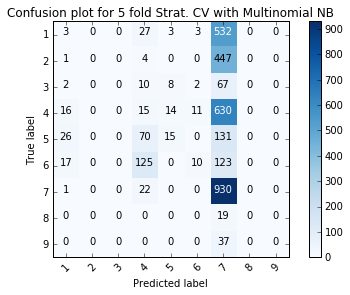

['multinomial_nb.pkl']

In [71]:
#Multinomial NB
model = MultinomialNB()
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with Multinomial NB')
joblib.dump(model, "multinomial_nb.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.3s finished
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Log loss:  1.76259870904
Accuracy:  0.34899126769
             precision    recall  f1-score   support

          1       0.33      0.33      0.33       568
          2       0.25      0.15      0.19       452
          3       0.00      0.00      0.00        89
          4       0.21      0.09      0.13       686
          5       0.27      0.27      0.27       242
          6       0.40      0.31      0.35       275
          7       0.41      0.72      0.52       953
          8       0.00      0.00      0.00        19
          9       0.15      0.05      0.08        37

avg / total       0.30      0.35      0.31      3321



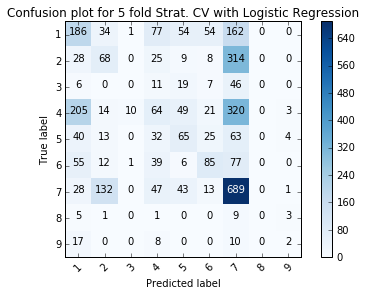

['logistic_regr.pkl']

In [74]:
#Logistic Regression
model = LogisticRegression()
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with Logistic Regression')
joblib.dump(model, "logistic_regr.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.8min finished


Log loss:  1.95886389598
Accuracy:  0.318277627221
             precision    recall  f1-score   support

          1       0.32      0.40      0.35       568
          2       0.28      0.31      0.29       452
          3       0.00      0.00      0.00        89
          4       0.24      0.12      0.16       686
          5       0.20      0.29      0.23       242
          6       0.35      0.31      0.33       275
          7       0.41      0.46      0.44       953
          8       0.14      0.05      0.08        19
          9       0.35      0.22      0.27        37

avg / total       0.31      0.32      0.31      3321



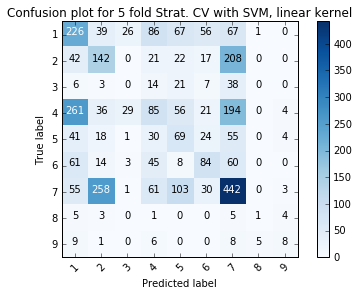

['svm_linear.pkl']

In [75]:
#svc with linear kernel
model = svm.SVC(C = 0.3, kernel = 'linear', probability = True)
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with SVM, linear kernel')
joblib.dump(model, "svm_linear.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.1min finished
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Log loss:  2.61169796073
Accuracy:  0.227642276423
             precision    recall  f1-score   support

          1       0.22      0.82      0.34       568
          2       0.24      0.41      0.30       452
          3       0.00      0.00      0.00        89
          4       0.00      0.00      0.00       686
          5       0.29      0.33      0.31       242
          6       0.26      0.04      0.06       275
          7       0.26      0.01      0.03       953
          8       0.00      0.00      0.00        19
          9       0.15      0.05      0.08        37

avg / total       0.19      0.23      0.14      3321



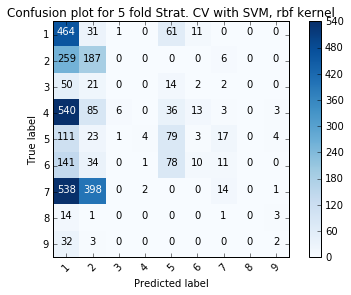

['svm_rbf.pkl']

In [76]:
model = svm.SVC(C = 0.3, kernel = 'rbf', probability = True)
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with SVM, rbf kernel')
joblib.dump(model, "svm_rbf.pkl",compress=1)

Cross validating model using 5-fold Stratified cross validation...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 30.8min finished


Log loss:  1.69365961799
Accuracy:  0.399578440229


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          1       0.30      0.20      0.24       568
          2       0.18      0.03      0.05       452
          3       0.00      0.00      0.00        89
          4       0.42      0.28      0.34       686
          5       0.29      0.24      0.26       242
          6       0.43      0.26      0.33       275
          7       0.43      0.92      0.59       953
          8       0.00      0.00      0.00        19
          9       0.00      0.00      0.00        37

avg / total       0.34      0.40      0.33      3321



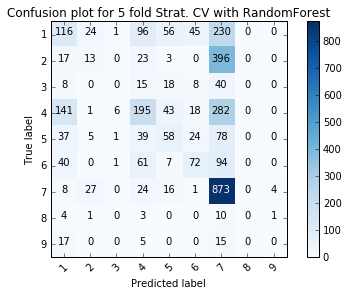

['rand_for.pkl']

In [78]:
model = RandomForestClassifier(n_estimators=1000, max_depth=15)
model = crossval_evaluate_model(model,X_new,y,'Confusion plot for 5 fold Strat. CV with RandomForest')
joblib.dump(model, "rand_for.pkl",compress=1)